## Model Selection and parameter optimization

As we have seen, we consider two different *sources* of features:  
- Bag-of-Words representation of text in the messages,
- General properties of message body: length, number of numerical and non-word characters.  

The extraction of both features requires different processing pipelines that should be combined to feed the model. This can be conducted using `Pipeline`, and `FeatureUnion` classes.

In addition, this problem has three main sources of hyper-parameters (e.g. parameters not optimized during the training):  
- Vectorizer parameters for tokenizing strategy (n-grams range, min. document frecuency, etc)  
- Specific parameters from each learning algorithm (Bayes: smoothing alpha, etc.)  
- Regularization parameters (C (for SMV and Logit), penalty type (l1,l2) ).

The best performing model will be obtained as an specific combination of values in the hyper-parameters space. Such combination can be obtained by means of **cross-validation**. In scikit-learn the `GridSearchCV` class allows to search the best hyper-parameters of a `Pipeline` within a defined array of values.

In [3]:
import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

In [4]:
df = pd.read_csv('spam.csv')
df['target'] = np.where(df['target']=='spam',1,0)
df['msg_len']  = df['text'].str.len()
df['non_word_char'] = df["text"].str.count(r'\W')
df['num_char'] = df["text"].str.count(r'\d')
X_train, X_test, y_train, y_test = train_test_split(df[['text','msg_len','non_word_char','num_char']],
                                                    df['target'], random_state=0,train_size=0.85)

In [5]:
def plot_cross_validation_results(parameters,grid_search):
    n = len(parameters)
    fig, _ = plt.subplots(n-1,n-1,figsize=(1.85*n,1.85*n),sharex='col',sharey='row')    
    hyper_param = [i.split("__")[-1] for i in parameters.keys()]    
    cv_res = pd.DataFrame(grid_search.cv_results_)
    name_formater = lambda i: 'param_'+ list(parameters.keys())[i]
    
    for i in range(n):
        for j in range(n):
            if j>=i: continue
            cv_pvt = pd.pivot_table(cv_res, values='mean_test_score',index= name_formater(i), columns=name_formater(j))
            z = (i-1)*(n-1) + (j+1)
            ax = plt.subplot(n-1,n-1,z)
            sns.heatmap(cv_pvt,annot=True,cbar=False,vmin=0.8,vmax=1.0,cmap="cividis",linewidths=.005)

            if i<n-1: ax.get_xaxis().set_visible(False)
            else: ax.set_xlabel(hyper_param[j])
            
            if j>0: ax.get_yaxis().set_visible(False)
            else: ax.set_ylabel(hyper_param[i])
    plt.subplots_adjust(left=.06,right=.97,top=0.98,bottom=0.11,wspace=0.04,hspace=0.04)
    #plt.tight_layout()    
    return

## a. GridSearch for BoW features alone

<IPython.core.display.Javascript object>


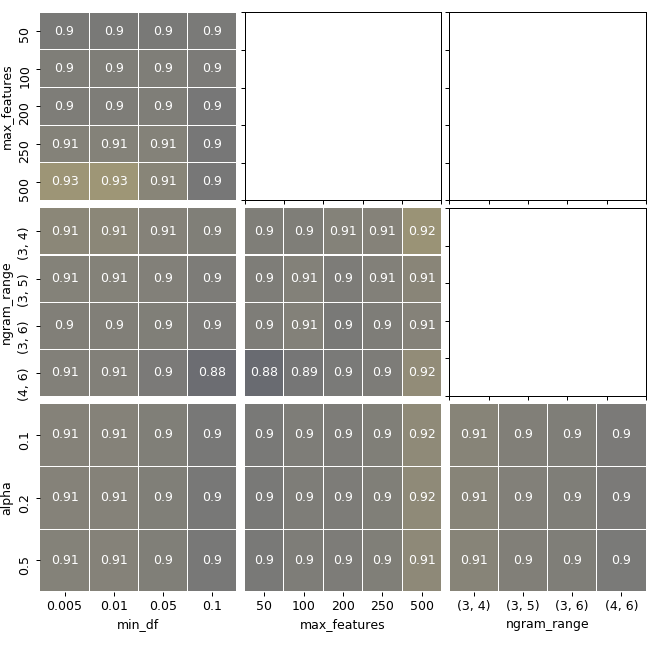

CPU times: user 11 s, sys: 413 ms, total: 11.4 s
Wall time: 3min 27s


In [14]:
%%time 
pipeline = Pipeline([
        ('vectorizer',CountVectorizer(analyzer='char_wb')),
        ('clf',MultinomialNB())
    ])
parameters = {
    'vectorizer__min_df': (5e-3, 1e-2,5e-2,1e-1),
    'vectorizer__max_features' : (50,100,200,250,500),
    'vectorizer__ngram_range' : ((3,4),(3,5),(3,6),(4,6)),
    'clf__alpha' : (0.1,0.2,0.5)
}
grid_search_nb = GridSearchCV(pipeline,parameters, cv=5, n_jobs=-1,verbose=0)
grid_search_nb.fit(X_train["text"],y_train)
plot_cross_validation_results(parameters,grid_search_nb)

## b. Combining Features from different sources 

The features chosen for this problem have different extraction pipelines:

- `X_train`==> select `['text']`  ==> `CountVectorizer` (BoW representation) ==> sparse matrix features

- `X_train`==> select `['msg_len','non_word_char','num_char']` ==> `RobustScaler` (Normalize data) ==> sparse matrix features

The features can be extracted with `Pipeline`  and then combined with `FeatureUnion`. 

In [6]:
# The following Transformer classes are largely based on the following link:
# https://scikit-learn.org/0.19/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]

class ConvertToDictList(BaseEstimator, TransformerMixin):
    """Convert input df or series to list of dictionaries for DictVectorizer"""
    def fit(self, x,y=None):
        return self
    def transform(self,df):
        return list(df.to_dict(orient='index').values())

In [7]:
feat_sources = [
    # pipeline for generating features describing body properties of the msg
    ('body_stats', Pipeline([('selector' , ItemSelector(key=['msg_len','non_word_char','num_char']) ),
                        ('conv_dic' , ConvertToDictList() ),
                        ('stat_vect', DictVectorizer()    ),
                        ('scaler',    RobustScaler(with_centering=False))
                             ]) 
    ),
    # pipeline for generating features from bag-of-words representation
    ('bow', Pipeline([('selector', ItemSelector(key='text') ),
                      ('vectorizer',CountVectorizer(analyzer='char_wb'))
                     ])
    )
]
combined_feat = FeatureUnion(feat_sources)
#combined_feat.get_params()

The descriptive features have been scaled and normalized using a `RobustScaler` which considers only the quartiles from the 25% up to the 75% of the population to estimate the normalization parameters. In this way the scaling transformation is more robust to outliers (see kde figures from section 1.)

In [11]:
%%time 

pipeline = Pipeline([
        ('feat_ext',combined_feat),
        ('clf',LogisticRegression())
    ])

parameters = {
    'feat_ext__bow__vectorizer__min_df': (1e-2,5e-2,1e-1),
    'feat_ext__bow__vectorizer__max_features' : (50,100,200,250),
    'feat_ext__bow__vectorizer__ngram_range' : ((3,4),(3,5),(3,6)),
    'clf__C' : (1e-2,1e-1,1,10,1e2),
    'clf__penalty': ('l1','l2')
}

grid_search_nb = GridSearchCV(pipeline,parameters, cv=5, n_jobs=-1,verbose=0)
grid_search_nb.fit(X_train,y_train)

CPU times: user 23.7 s, sys: 556 ms, total: 24.3 s
Wall time: 7min 17s


/home/cesarliz10/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<IPython.core.display.Javascript object>


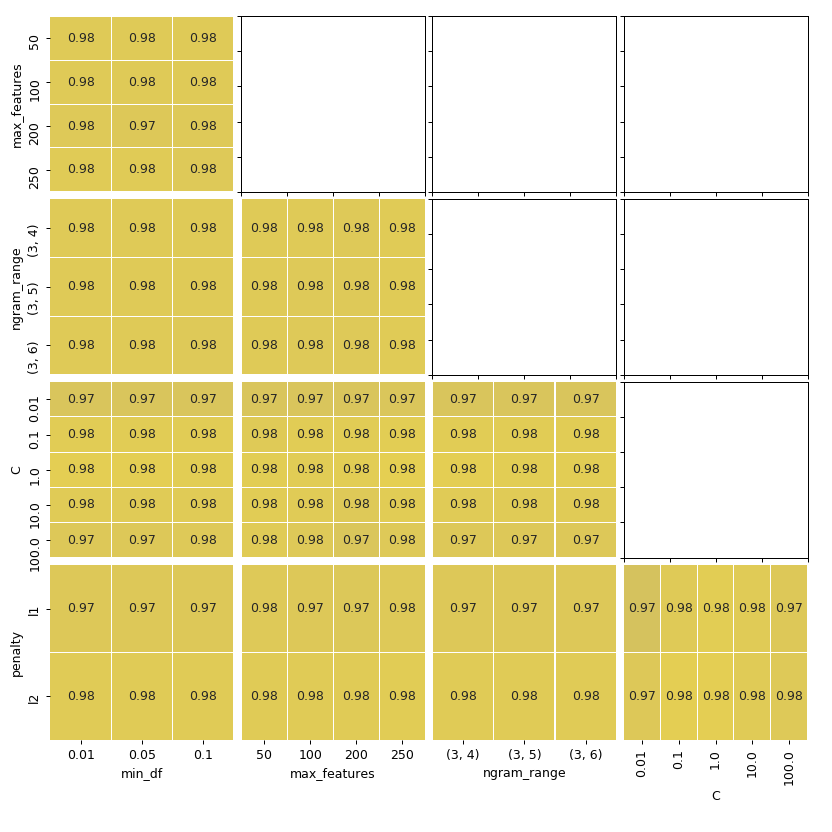

In [12]:
plot_cross_validation_results(parameters,grid_search_nb)

<IPython.core.display.Javascript object>


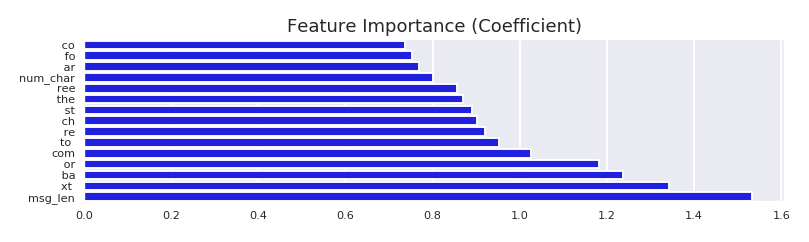

In [22]:
model = grid_search_nb.best_estimator_
sns.set(style='darkgrid',context='talk',palette='Blues_r',font_scale=0.8)
coefficients =  grid_search_nb.best_estimator_['clf'].coef_[0]
sorted_coef_index = coefficients.argsort()
fe = grid_search_nb.best_estimator_['feat_ext']
feature_names = fe.get_params()['body_stats'].get_params()['stat_vect'].get_feature_names() + fe.get_params()['bow'].get_params()['vectorizer'].get_feature_names()
feature_names = np.array( feature_names )
feature_names = feature_names[ sorted_coef_index ].astype('str')
n = 15
plt.figure(figsize=(9,0.18*n))
feat = feature_names[-n:]
coef = coefficients[sorted_coef_index][-n:]
ax = sns.barplot(y=feat,x=coef,orient='h',color='Blue')
ax.axes.set_title("Feature Importance (Coefficient)")
ax.tick_params(labelsize=9,which='major',pad=-2)
plt.tight_layout()

## c. Error estimation of model:

In [24]:
from sklearn.metrics import confusion_matrix
test_predictions = grid_search_nb.predict(X_test)

> AUC score for test data:

In [27]:
roc_auc_score(y_test,test_predictions)

0.9698313912429379

> Confusion Matrix for test data:

In [33]:
cm = pd.DataFrame(data=confusion_matrix(y_test,test_predictions))
cm.set_index(pd.Index(['Real ham','Real spam']),inplace=True)
cm.columns=(['Predicted ham','Predicted spam'])
cm

,Predicted ham,Predicted spam
Real ham,704,4
Real spam,7,121
